In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsModifiedDataset
from pathlib import Path

import matplotlib.pyplot as plt

from dtw import dtw

In [2]:
# Dataset loader
datapath = Path('data')
dataset = TsModifiedDataset(datapath/'CaseI-Attacks without any change.csv', noise_type='none')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        shuffle=True, num_workers=4)
print("The size of the dataset is: ", dataset.data_normal.size(), dataset.data_attacked.size())

The size of the dataset is:  torch.Size([33, 15, 1973]) torch.Size([33, 15, 1973])


In [3]:
normal_seq_len = dataset.data_normal.size(1)
normal_feature_len = dataset.data_normal.size(2)
attacked_seq_len = dataset.data_attacked.size(1)
attacked_feature_len = dataset.data_attacked.size(2)

In [4]:
G_AB = LSTMFullGenerator(normal_seq_len, normal_feature_len)
G_BA = LSTMFullGenerator(attacked_seq_len, attacked_feature_len)
D_A = LSTMFullDiscriminator(normal_feature_len)
D_B = LSTMFullDiscriminator(normal_feature_len)

In [5]:
G_AB.load_state_dict(torch.load("saved_models/cyber_other/G_AB_190.pth"))
G_BA.load_state_dict(torch.load("saved_models/cyber_other/G_BA_190.pth"))
D_A.load_state_dict(torch.load("saved_models/cyber_other/D_A_190.pth"))
D_B.load_state_dict(torch.load("saved_models/cyber_other/D_B_190.pth"))

<All keys matched successfully>

In [6]:
G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMFullDiscriminator(
  (lstm): LSTM(1973, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1973, bias=True)
    (1): Sigmoid()
  )
)

In [7]:
threshold = 2.00

In [8]:
dataset_test = TsModifiedDataset(datapath/'CaseII.csv', noise_type='none')
# dataset_test = TsFinalDataset(datapath/'CaseI-Attacks without any change.csv', noise_type='none')
dataset_test.data_normal.size()

torch.Size([33, 15, 1973])

In [9]:
with torch.no_grad():
    output = G_AB(dataset_test.data_normal)
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([33, 15, 1973]) 	 Output Back size: torch.Size([33, 15, 1973])


In [10]:
os.makedirs('cyber_result/other/forward', exist_ok=True)
forward_res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, 0, :].numpy())
    plt.plot(output_back[i, 0, :].numpy())
    plt.plot(dataset_test.data_normal[i, 0, :].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/other/forward/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), dataset_test.data_normal[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), dataset_test.data_normal[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    res = (dist2+dist3)/dist1
    print("+" if res < threshold else "-", res)
    forward_res_list.append(res)

+ 1.003391131318834
+ 0.9973378503478892
+ 1.0041354120141435
+ 1.0062324340786528
+ 0.9817541017174632
+ 0.9906069926906169
+ 0.9906069926906169
+ 0.9820460130240478
+ 0.9800574260840922
+ 0.980076705572252
+ 0.9762056814363163
+ 0.9749520279742078
+ 0.9716759935084921
- 3.6988809128017235
+ 1.082676956205937
+ 1.1216437804002644
+ 1.0391446854836628
+ 1.1344544785570985
+ 1.0207776893248106
+ 1.1192419600300632
+ 0.9330662636991462
+ 0.9539501370610306
+ 1.1022007618257124
+ 1.0929486807208006
+ 0.9785979089712041
+ 0.9879984947548368
+ 0.9880474447401981
+ 0.9330662636991462
+ 0.9946879510364633
+ 0.9811173264799308
+ 1.0158475633054358
+ 0.9970446999177699
+ 1.0536057410881188


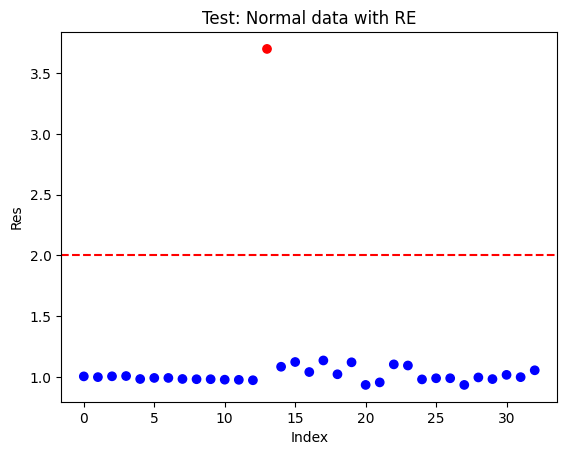

In [11]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in forward_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(forward_res_list)), forward_res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Test: Normal data with RE')
plt.show()

---

In [12]:
dataset_test.data_attacked.size()

torch.Size([33, 15, 1973])

In [16]:
data_attacked_test = dataset_test.data_attacked
data_attacked_test.size()

torch.Size([33, 15, 1973])

In [17]:
with torch.no_grad():
    output = G_AB(data_attacked_test)
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([33, 15, 1973]) 	 Output Back size: torch.Size([33, 15, 1973])


In [18]:
os.makedirs('cyber_result/other/detection', exist_ok=True)
detection_res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, 0, :].numpy())
    plt.plot(output_back[i, 0, :].numpy())
    plt.plot(data_attacked_test[i, 0, :].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/other/detection/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), data_attacked_test[i, 0, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), data_attacked_test[i, 0, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1)) 
    res = (dist2+dist3)/dist1   
    print("+" if res < threshold else "-", res)
    detection_res_list.append(res)

+ 0.9439660723121502
+ 0.9382833767903908
+ 0.9386481097266643
+ 0.9423767328268395
+ 0.9385262477023683
+ 0.9378376625841548
+ 0.9378376625841548
+ 0.9375129075940756
+ 0.9375467971560864
+ 0.9379110412208131
+ 0.9380367461824122
+ 0.9379316992014937
+ 0.9373574603730317
- 6.3249332515458905
+ 1.238389281528071
+ 1.0865450923267683
+ 1.1059200503005215
+ 0.9664854005909838
+ 0.9407003800086556
+ 0.9496385912102504
+ 0.967892760205002
+ 0.9523135805628803
+ 1.3326783088824126
+ 0.9541347320959614
+ 0.9531076685705949
+ 0.9837620026966623
+ 0.9496385912102504
+ 0.967892760205002
+ 0.945742127925134
+ 0.9537043150867753
+ 0.93936319726552
+ 0.9528257294857839
+ 0.9501308383551715


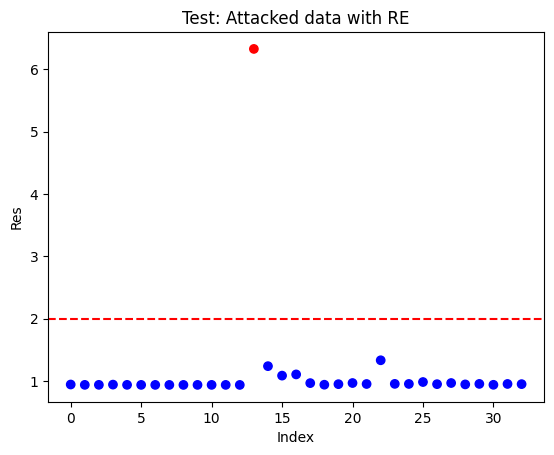

In [19]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in detection_res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(detection_res_list)), detection_res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Test: Attacked data with RE')
plt.show()

In [20]:
sorted(forward_res_list, reverse=True)

[3.6988809128017235,
 1.1344544785570985,
 1.1216437804002644,
 1.1192419600300632,
 1.1022007618257124,
 1.0929486807208006,
 1.082676956205937,
 1.0536057410881188,
 1.0391446854836628,
 1.0207776893248106,
 1.0158475633054358,
 1.0062324340786528,
 1.0041354120141435,
 1.003391131318834,
 0.9973378503478892,
 0.9970446999177699,
 0.9946879510364633,
 0.9906069926906169,
 0.9906069926906169,
 0.9880474447401981,
 0.9879984947548368,
 0.9820460130240478,
 0.9817541017174632,
 0.9811173264799308,
 0.980076705572252,
 0.9800574260840922,
 0.9785979089712041,
 0.9762056814363163,
 0.9749520279742078,
 0.9716759935084921,
 0.9539501370610306,
 0.9330662636991462,
 0.9330662636991462]

In [21]:
sorted(detection_res_list, reverse=True)

[6.3249332515458905,
 1.3326783088824126,
 1.238389281528071,
 1.1059200503005215,
 1.0865450923267683,
 0.9837620026966623,
 0.967892760205002,
 0.967892760205002,
 0.9664854005909838,
 0.9541347320959614,
 0.9537043150867753,
 0.9531076685705949,
 0.9528257294857839,
 0.9523135805628803,
 0.9501308383551715,
 0.9496385912102504,
 0.9496385912102504,
 0.945742127925134,
 0.9439660723121502,
 0.9423767328268395,
 0.9407003800086556,
 0.93936319726552,
 0.9386481097266643,
 0.9385262477023683,
 0.9382833767903908,
 0.9380367461824122,
 0.9379316992014937,
 0.9379110412208131,
 0.9378376625841548,
 0.9378376625841548,
 0.9375467971560864,
 0.9375129075940756,
 0.9373574603730317]